In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

In [2]:
# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)
is_valid = True
# For Validation set
if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]

In [3]:
def loadData2D(is_valid=True):
    # Loading data
    data = np.load('data2D.npy')
    #data = np.load('data100D.npy')
    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]
        print(val_data.shape)
        print(data.shape)
        
def loadData100D(is_valid=True):
    # Loading data
    data = np.load('data100D.npy')
    #data = np.load('data100D.npy')
    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]
        print(val_data.shape)
        print(data.shape)

In [4]:
# Figure out the size of trainData and validationData
loadData2D()
loadData100D()

(3333, 2)
(6667, 2)
(3333, 100)
(6667, 100)


In [5]:
# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    return tf.reduce_sum(tf.square(tf.expand_dims(X,1)-tf.expand_dims(MU,0)),2)

In [6]:
#param learning_rate: optimizer's learning rate
def buildGraph(learning_rate=0.01, dim=2, k=3):
    # Variable creation
    input_x = tf.placeholder(tf.float32, [None, dim], name='input_x')
    k_centers = tf.Variable(tf.random_normal([k, dim], stddev=0.5))
    data_size = tf.placeholder(tf.float32)
    distance = distanceFunc(input_x,k_centers)
    loss = (tf.reduce_sum(tf.reduce_min(distance, 1))) / data_size
    prediction = tf.argmin(distance,1)
    # using adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.99,epsilon=1e-5).minimize(loss=loss)
    return input_x, loss, optimizer, prediction, k_centers, data_size

In [7]:
def part1(k, epochs = 1000):
    input_x, loss, optimizer, prediction, k_centers, data_size = buildGraph(learning_rate= 0.01, k=k, dim=dim)
    init = tf.initializers.global_variables()
    TrainLoss_tol = []
    ValidLoss_tol = []
    precentile = np.zeros((k))
    with tf.Session() as sess:
        sess.run(init)
        #loss_epo = 0
        # train every epoch
        config = "Adam_{}_{}".format(k, is_valid)
        print(config)
        for epoch in range(epochs):
            # Train loss with trainData
            a, c_epo = sess.run([optimizer, loss], feed_dict={input_x: data, data_size: data.shape[0]})
            print("Epoch:{}".format(epoch+1), "loss={}".format(c_epo))
            train_loss, train_prediction = sess.run([loss, prediction], feed_dict={input_x: data, data_size: data.shape[0]})
            TrainLoss_tol.append(train_loss)
            if is_valid:
                valid_loss, val_prediction = sess.run([loss, prediction], feed_dict={input_x: val_data, data_size: val_data.shape[0]})
                ValidLoss_tol.append(valid_loss)
        print("Finish Adam_{}_{}".format(k, is_valid))
        centers = sess.run(k_centers)
        for cluster_k in range(k):
            precentile[cluster_k] = np.sum(np.where(train_prediction==cluster_k,1,0))/train_prediction.size
        np.save("./output/trainlabel_{}.npy".format(config), train_prediction)
        np.save("./output/trainloss_{}.npy".format(config), np.array(TrainLoss_tol))
        if is_valid:
            np.save("./output/validloss_{}.npy".format(config),np.array(ValidLoss_tol))
        plot_graph(config=config)
        if not is_valid:
            plot_scatter(k, data, train_prediction, centers=centers)
        else:
            plot_scatter(k, val_data, val_prediction, centers=centers)

In [8]:
def plot_graph(config):
    train_data = np.load("./output/trainloss_{}.npy".format(config))
    if is_valid:
        val_data = np.load("./output/validloss_{}.npy".format(config))
        min_val = min(val_data)
    else:
        min_val = "Null"
        val_data = ["Null"]
    n = len(train_data)
    step_num = np.arange(1,n+1,1)
    plt.figure()
    width = int(len(train_data)/100)*2+1
    width = max(width, 5)
    min_train = min(train_data)
    plt.title("The average loss over training epochs")
    plt.plot(step_num, train_data, label="Train")
    if is_valid:
        plt.plot(step_num, val_data, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend(loc='best')
    plt.savefig("./output_pic/loss{}_min_train.png".format(config))
    return

In [9]:
def plot_scatter(k, traindata, prediction, centers):
    color_list = ["b","g","r","y","c"]
    clabel = []
    for i in range(len(prediction)):
        clabel.append(color_list[prediction[i]])
    plt.figure()
    plt.title("prediction data points with {} clusters".format(k))
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.scatter(traindata[:,0], traindata[:,1], c=clabel, marker='.')
    plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x')
    plt.savefig("./output_pic/{}_cluster_plot_{}.png".format(k, is_valid))

Adam_1_True
Epoch:1 loss=4.7449235916137695
Epoch:2 loss=4.722320556640625
Epoch:3 loss=4.7001261711120605
Epoch:4 loss=4.678348541259766
Epoch:5 loss=4.6569976806640625
Epoch:6 loss=4.63607120513916
Epoch:7 loss=4.61557674407959
Epoch:8 loss=4.595513343811035
Epoch:9 loss=4.575886249542236
Epoch:10 loss=4.556699752807617
Epoch:11 loss=4.537947654724121
Epoch:12 loss=4.519631385803223
Epoch:13 loss=4.501746654510498
Epoch:14 loss=4.484292507171631
Epoch:15 loss=4.467264652252197
Epoch:16 loss=4.450652599334717
Epoch:17 loss=4.434452056884766
Epoch:18 loss=4.418652057647705
Epoch:19 loss=4.403246879577637
Epoch:20 loss=4.38822078704834
Epoch:21 loss=4.373558044433594
Epoch:22 loss=4.359260559082031
Epoch:23 loss=4.345299243927002
Epoch:24 loss=4.331666469573975
Epoch:25 loss=4.3183512687683105
Epoch:26 loss=4.30533504486084
Epoch:27 loss=4.292607307434082
Epoch:28 loss=4.280150413513184
Epoch:29 loss=4.267959117889404
Epoch:30 loss=4.25601863861084
Epoch:31 loss=4.24432373046875
Epoch:3

Epoch:267 loss=3.838157892227173
Epoch:268 loss=3.8381574153900146
Epoch:269 loss=3.8381569385528564
Epoch:270 loss=3.8381567001342773
Epoch:271 loss=3.838156223297119
Epoch:272 loss=3.8381569385528564
Epoch:273 loss=3.838156223297119
Epoch:274 loss=3.838155746459961
Epoch:275 loss=3.83815598487854
Epoch:276 loss=3.838156223297119
Epoch:277 loss=3.8381567001342773
Epoch:278 loss=3.8381569385528564
Epoch:279 loss=3.8381567001342773
Epoch:280 loss=3.8381569385528564
Epoch:281 loss=3.8381567001342773
Epoch:282 loss=3.8381571769714355
Epoch:283 loss=3.8381567001342773
Epoch:284 loss=3.8381569385528564
Epoch:285 loss=3.8381567001342773
Epoch:286 loss=3.8381567001342773
Epoch:287 loss=3.83815598487854
Epoch:288 loss=3.83815598487854
Epoch:289 loss=3.838155508041382
Epoch:290 loss=3.83815598487854
Epoch:291 loss=3.8381567001342773
Epoch:292 loss=3.838156223297119
Epoch:293 loss=3.8381569385528564
Epoch:294 loss=3.8381567001342773
Epoch:295 loss=3.8381567001342773
Epoch:296 loss=3.838156700134

Epoch:544 loss=3.8381574153900146
Epoch:545 loss=3.8381574153900146
Epoch:546 loss=3.8381574153900146
Epoch:547 loss=3.8381574153900146
Epoch:548 loss=3.8381574153900146
Epoch:549 loss=3.8381574153900146
Epoch:550 loss=3.8381574153900146
Epoch:551 loss=3.8381574153900146
Epoch:552 loss=3.8381574153900146
Epoch:553 loss=3.8381574153900146
Epoch:554 loss=3.8381574153900146
Epoch:555 loss=3.8381574153900146
Epoch:556 loss=3.838157892227173
Epoch:557 loss=3.8381574153900146
Epoch:558 loss=3.8381574153900146
Epoch:559 loss=3.8381574153900146
Epoch:560 loss=3.8381574153900146
Epoch:561 loss=3.8381574153900146
Epoch:562 loss=3.8381574153900146
Epoch:563 loss=3.8381574153900146
Epoch:564 loss=3.8381574153900146
Epoch:565 loss=3.8381574153900146
Epoch:566 loss=3.838157892227173
Epoch:567 loss=3.8381574153900146
Epoch:568 loss=3.8381574153900146
Epoch:569 loss=3.8381574153900146
Epoch:570 loss=3.8381574153900146
Epoch:571 loss=3.838157892227173
Epoch:572 loss=3.838157892227173
Epoch:573 loss=3.8

Epoch:849 loss=3.838158130645752
Epoch:850 loss=3.838157892227173
Epoch:851 loss=3.838157892227173
Epoch:852 loss=3.838157892227173
Epoch:853 loss=3.838158130645752
Epoch:854 loss=3.838158130645752
Epoch:855 loss=3.838157892227173
Epoch:856 loss=3.838157892227173
Epoch:857 loss=3.838157892227173
Epoch:858 loss=3.838158130645752
Epoch:859 loss=3.838158130645752
Epoch:860 loss=3.838157892227173
Epoch:861 loss=3.838157892227173
Epoch:862 loss=3.838157892227173
Epoch:863 loss=3.838158130645752
Epoch:864 loss=3.838158130645752
Epoch:865 loss=3.838157892227173
Epoch:866 loss=3.838157892227173
Epoch:867 loss=3.838157892227173
Epoch:868 loss=3.838158130645752
Epoch:869 loss=3.838158130645752
Epoch:870 loss=3.838157892227173
Epoch:871 loss=3.838157892227173
Epoch:872 loss=3.838157892227173
Epoch:873 loss=3.838158130645752
Epoch:874 loss=3.838158130645752
Epoch:875 loss=3.838157892227173
Epoch:876 loss=3.838157892227173
Epoch:877 loss=3.838157892227173
Epoch:878 loss=3.838158130645752
Epoch:879 

Epoch:104 loss=2.731127977371216
Epoch:105 loss=2.7108826637268066
Epoch:106 loss=2.690812110900879
Epoch:107 loss=2.670945405960083
Epoch:108 loss=2.6512598991394043
Epoch:109 loss=2.6317765712738037
Epoch:110 loss=2.612484931945801
Epoch:111 loss=2.5933732986450195
Epoch:112 loss=2.574460506439209
Epoch:113 loss=2.555745840072632
Epoch:114 loss=2.5372071266174316
Epoch:115 loss=2.5188400745391846
Epoch:116 loss=2.5006561279296875
Epoch:117 loss=2.4826579093933105
Epoch:118 loss=2.4648241996765137
Epoch:119 loss=2.447181463241577
Epoch:120 loss=2.429701566696167
Epoch:121 loss=2.412367820739746
Epoch:122 loss=2.3951961994171143
Epoch:123 loss=2.378175973892212
Epoch:124 loss=2.361311197280884
Epoch:125 loss=2.34462308883667
Epoch:126 loss=2.3280982971191406
Epoch:127 loss=2.311725378036499
Epoch:128 loss=2.295506715774536
Epoch:129 loss=2.2794547080993652
Epoch:130 loss=2.2635722160339355
Epoch:131 loss=2.2478485107421875
Epoch:132 loss=2.232273817062378
Epoch:133 loss=2.2168517112731

Epoch:354 loss=0.9723048806190491
Epoch:355 loss=0.9715180993080139
Epoch:356 loss=0.9707419276237488
Epoch:357 loss=0.9699797630310059
Epoch:358 loss=0.9692322611808777
Epoch:359 loss=0.9684955477714539
Epoch:360 loss=0.967770516872406
Epoch:361 loss=0.9670543074607849
Epoch:362 loss=0.9663531184196472
Epoch:363 loss=0.9656612277030945
Epoch:364 loss=0.9649768471717834
Epoch:365 loss=0.9643029570579529
Epoch:366 loss=0.9636440873146057
Epoch:367 loss=0.9629963636398315
Epoch:368 loss=0.9623583555221558
Epoch:369 loss=0.9617315530776978
Epoch:370 loss=0.9611161351203918
Epoch:371 loss=0.9605109095573425
Epoch:372 loss=0.9599180817604065
Epoch:373 loss=0.9593355655670166
Epoch:374 loss=0.9587657451629639
Epoch:375 loss=0.958203136920929
Epoch:376 loss=0.9576514959335327
Epoch:377 loss=0.9571129083633423
Epoch:378 loss=0.9565830826759338
Epoch:379 loss=0.9560660123825073
Epoch:380 loss=0.9555553197860718
Epoch:381 loss=0.9550532102584839
Epoch:382 loss=0.9545601010322571
Epoch:383 loss=0

Epoch:613 loss=0.9364538788795471
Epoch:614 loss=0.9364539980888367
Epoch:615 loss=0.9364538788795471
Epoch:616 loss=0.9364537000656128
Epoch:617 loss=0.9364537000656128
Epoch:618 loss=0.936453640460968
Epoch:619 loss=0.9364535808563232
Epoch:620 loss=0.9364534020423889
Epoch:621 loss=0.9364532828330994
Epoch:622 loss=0.936453640460968
Epoch:623 loss=0.9364535808563232
Epoch:624 loss=0.9364534020423889
Epoch:625 loss=0.9364532828330994
Epoch:626 loss=0.9364533424377441
Epoch:627 loss=0.9364532828330994
Epoch:628 loss=0.9364534020423889
Epoch:629 loss=0.9364532828330994
Epoch:630 loss=0.9364530444145203
Epoch:631 loss=0.9364528059959412
Epoch:632 loss=0.9364529848098755
Epoch:633 loss=0.9364529252052307
Epoch:634 loss=0.9364529252052307
Epoch:635 loss=0.9364530444145203
Epoch:636 loss=0.9364532232284546
Epoch:637 loss=0.9364532232284546
Epoch:638 loss=0.9364532232284546
Epoch:639 loss=0.9364532828330994
Epoch:640 loss=0.9364533424377441
Epoch:641 loss=0.9364533424377441
Epoch:642 loss=0

Epoch:877 loss=0.936453640460968
Epoch:878 loss=0.936453640460968
Epoch:879 loss=0.936453640460968
Epoch:880 loss=0.936453640460968
Epoch:881 loss=0.936453640460968
Epoch:882 loss=0.936453640460968
Epoch:883 loss=0.936453640460968
Epoch:884 loss=0.936453640460968
Epoch:885 loss=0.936453640460968
Epoch:886 loss=0.936453640460968
Epoch:887 loss=0.936453640460968
Epoch:888 loss=0.936453640460968
Epoch:889 loss=0.936453640460968
Epoch:890 loss=0.936453640460968
Epoch:891 loss=0.936453640460968
Epoch:892 loss=0.936453640460968
Epoch:893 loss=0.936453640460968
Epoch:894 loss=0.936453640460968
Epoch:895 loss=0.936453640460968
Epoch:896 loss=0.9364535808563232
Epoch:897 loss=0.936453640460968
Epoch:898 loss=0.9364535808563232
Epoch:899 loss=0.936453640460968
Epoch:900 loss=0.9364535808563232
Epoch:901 loss=0.936453640460968
Epoch:902 loss=0.936453640460968
Epoch:903 loss=0.936453640460968
Epoch:904 loss=0.936453640460968
Epoch:905 loss=0.936453640460968
Epoch:906 loss=0.936453640460968
Epoch:9

Epoch:132 loss=2.383429765701294
Epoch:133 loss=2.3673365116119385
Epoch:134 loss=2.3513689041137695
Epoch:135 loss=2.335527181625366
Epoch:136 loss=2.3198111057281494
Epoch:137 loss=2.3042190074920654
Epoch:138 loss=2.2887511253356934
Epoch:139 loss=2.2734031677246094
Epoch:140 loss=2.2581734657287598
Epoch:141 loss=2.243054151535034
Epoch:142 loss=2.2280523777008057
Epoch:143 loss=2.213167667388916
Epoch:144 loss=2.198392868041992
Epoch:145 loss=2.1837360858917236
Epoch:146 loss=2.16919207572937
Epoch:147 loss=2.154761791229248
Epoch:148 loss=2.1404428482055664
Epoch:149 loss=2.126237392425537
Epoch:150 loss=2.1121408939361572
Epoch:151 loss=2.098156213760376
Epoch:152 loss=2.084280014038086
Epoch:153 loss=2.070512533187866
Epoch:154 loss=2.0568509101867676
Epoch:155 loss=2.0432937145233154
Epoch:156 loss=2.029843807220459
Epoch:157 loss=2.0164976119995117
Epoch:158 loss=2.003255844116211
Epoch:159 loss=1.9901171922683716
Epoch:160 loss=1.9770779609680176
Epoch:161 loss=1.96414268016

Epoch:389 loss=0.6444323062896729
Epoch:390 loss=0.642708420753479
Epoch:391 loss=0.6410031318664551
Epoch:392 loss=0.6393201351165771
Epoch:393 loss=0.6376616358757019
Epoch:394 loss=0.6360204219818115
Epoch:395 loss=0.6343975067138672
Epoch:396 loss=0.6327933669090271
Epoch:397 loss=0.6312119960784912
Epoch:398 loss=0.6296520233154297
Epoch:399 loss=0.628114640712738
Epoch:400 loss=0.6265947222709656
Epoch:401 loss=0.6250906586647034
Epoch:402 loss=0.6236058473587036
Epoch:403 loss=0.6221349239349365
Epoch:404 loss=0.6206807494163513
Epoch:405 loss=0.6192396879196167
Epoch:406 loss=0.6178028583526611
Epoch:407 loss=0.6163737177848816
Epoch:408 loss=0.6149436235427856
Epoch:409 loss=0.6135167479515076
Epoch:410 loss=0.6121024489402771
Epoch:411 loss=0.6106951832771301
Epoch:412 loss=0.6093031167984009
Epoch:413 loss=0.6079229116439819
Epoch:414 loss=0.6065520644187927
Epoch:415 loss=0.6051867008209229
Epoch:416 loss=0.6038301587104797
Epoch:417 loss=0.6024893522262573
Epoch:418 loss=0

Epoch:639 loss=0.5233755111694336
Epoch:640 loss=0.5233737826347351
Epoch:641 loss=0.52337247133255
Epoch:642 loss=0.5233708024024963
Epoch:643 loss=0.5233692526817322
Epoch:644 loss=0.523368239402771
Epoch:645 loss=0.5233668684959412
Epoch:646 loss=0.5233657360076904
Epoch:647 loss=0.5233649015426636
Epoch:648 loss=0.5233639478683472
Epoch:649 loss=0.5233629941940308
Epoch:650 loss=0.5233623385429382
Epoch:651 loss=0.5233616232872009
Epoch:652 loss=0.5233607888221741
Epoch:653 loss=0.5233599543571472
Epoch:654 loss=0.5233594179153442
Epoch:655 loss=0.5233588814735413
Epoch:656 loss=0.5233585238456726
Epoch:657 loss=0.5233578085899353
Epoch:658 loss=0.5233573913574219
Epoch:659 loss=0.5233566164970398
Epoch:660 loss=0.5233561396598816
Epoch:661 loss=0.5233556032180786
Epoch:662 loss=0.5233554244041443
Epoch:663 loss=0.5233550071716309
Epoch:664 loss=0.5233546495437622
Epoch:665 loss=0.5233547687530518
Epoch:666 loss=0.5233541131019592
Epoch:667 loss=0.5233538746833801
Epoch:668 loss=0.

Epoch:895 loss=0.5233501195907593
Epoch:896 loss=0.5233501195907593
Epoch:897 loss=0.5233501195907593
Epoch:898 loss=0.5233501195907593
Epoch:899 loss=0.5233501195907593
Epoch:900 loss=0.5233501195907593
Epoch:901 loss=0.5233501195907593
Epoch:902 loss=0.5233501195907593
Epoch:903 loss=0.5233501195907593
Epoch:904 loss=0.5233501195907593
Epoch:905 loss=0.5233501195907593
Epoch:906 loss=0.5233501195907593
Epoch:907 loss=0.5233501195907593
Epoch:908 loss=0.5233501195907593
Epoch:909 loss=0.5233501195907593
Epoch:910 loss=0.5233501195907593
Epoch:911 loss=0.5233501195907593
Epoch:912 loss=0.5233501195907593
Epoch:913 loss=0.5233501195907593
Epoch:914 loss=0.5233501195907593
Epoch:915 loss=0.5233501195907593
Epoch:916 loss=0.5233501195907593
Epoch:917 loss=0.5233501195907593
Epoch:918 loss=0.5233501195907593
Epoch:919 loss=0.5233501195907593
Epoch:920 loss=0.5233501195907593
Epoch:921 loss=0.5233501195907593
Epoch:922 loss=0.5233501195907593
Epoch:923 loss=0.5233501195907593
Epoch:924 loss

Epoch:150 loss=1.178955316543579
Epoch:151 loss=1.1701440811157227
Epoch:152 loss=1.161406397819519
Epoch:153 loss=1.1527467966079712
Epoch:154 loss=1.1441600322723389
Epoch:155 loss=1.135648250579834
Epoch:156 loss=1.1272073984146118
Epoch:157 loss=1.1188418865203857
Epoch:158 loss=1.1105477809906006
Epoch:159 loss=1.1023311614990234
Epoch:160 loss=1.094183087348938
Epoch:161 loss=1.0861016511917114
Epoch:162 loss=1.0780915021896362
Epoch:163 loss=1.0701498985290527
Epoch:164 loss=1.0622782707214355
Epoch:165 loss=1.0544674396514893
Epoch:166 loss=1.0467275381088257
Epoch:167 loss=1.0390501022338867
Epoch:168 loss=1.0314403772354126
Epoch:169 loss=1.023892879486084
Epoch:170 loss=1.0164109468460083
Epoch:171 loss=1.0089884996414185
Epoch:172 loss=1.0016251802444458
Epoch:173 loss=0.9943258166313171
Epoch:174 loss=0.9870902299880981
Epoch:175 loss=0.9799200296401978
Epoch:176 loss=0.9728095531463623
Epoch:177 loss=0.9657585024833679
Epoch:178 loss=0.9587649703025818
Epoch:179 loss=0.95

Epoch:400 loss=0.3623531758785248
Epoch:401 loss=0.3619823157787323
Epoch:402 loss=0.3616196811199188
Epoch:403 loss=0.3612649440765381
Epoch:404 loss=0.36091846227645874
Epoch:405 loss=0.36057958006858826
Epoch:406 loss=0.36024942994117737
Epoch:407 loss=0.3599272668361664
Epoch:408 loss=0.3596128821372986
Epoch:409 loss=0.3593066334724426
Epoch:410 loss=0.3590080142021179
Epoch:411 loss=0.358714759349823
Epoch:412 loss=0.3584263324737549
Epoch:413 loss=0.35814452171325684
Epoch:414 loss=0.3578684329986572
Epoch:415 loss=0.3576008379459381
Epoch:416 loss=0.35734105110168457
Epoch:417 loss=0.35708606243133545
Epoch:418 loss=0.35683533549308777
Epoch:419 loss=0.35659098625183105
Epoch:420 loss=0.3563530743122101
Epoch:421 loss=0.3561197817325592
Epoch:422 loss=0.3558918237686157
Epoch:423 loss=0.355669766664505
Epoch:424 loss=0.35545340180397034
Epoch:425 loss=0.35524001717567444
Epoch:426 loss=0.3550296723842621
Epoch:427 loss=0.35482722520828247
Epoch:428 loss=0.3546311557292938
Epoch

Epoch:645 loss=0.34800636768341064
Epoch:646 loss=0.3480064272880554
Epoch:647 loss=0.34800630807876587
Epoch:648 loss=0.34800639748573303
Epoch:649 loss=0.34800636768341064
Epoch:650 loss=0.34800633788108826
Epoch:651 loss=0.3480064272880554
Epoch:652 loss=0.3480064272880554
Epoch:653 loss=0.34800639748573303
Epoch:654 loss=0.34800654649734497
Epoch:655 loss=0.34800639748573303
Epoch:656 loss=0.3480064272880554
Epoch:657 loss=0.34800633788108826
Epoch:658 loss=0.34800639748573303
Epoch:659 loss=0.34800633788108826
Epoch:660 loss=0.3480064868927002
Epoch:661 loss=0.34800654649734497
Epoch:662 loss=0.3480064868927002
Epoch:663 loss=0.34800639748573303
Epoch:664 loss=0.34800633788108826
Epoch:665 loss=0.34800633788108826
Epoch:666 loss=0.34800639748573303
Epoch:667 loss=0.3480064272880554
Epoch:668 loss=0.34800639748573303
Epoch:669 loss=0.34800639748573303
Epoch:670 loss=0.34800639748573303
Epoch:671 loss=0.3480065166950226
Epoch:672 loss=0.3480064868927002
Epoch:673 loss=0.348006486892

Epoch:896 loss=0.34800639748573303
Epoch:897 loss=0.34800639748573303
Epoch:898 loss=0.34800639748573303
Epoch:899 loss=0.34800639748573303
Epoch:900 loss=0.34800639748573303
Epoch:901 loss=0.34800639748573303
Epoch:902 loss=0.34800639748573303
Epoch:903 loss=0.34800639748573303
Epoch:904 loss=0.34800639748573303
Epoch:905 loss=0.34800639748573303
Epoch:906 loss=0.34800639748573303
Epoch:907 loss=0.34800639748573303
Epoch:908 loss=0.34800639748573303
Epoch:909 loss=0.3480064272880554
Epoch:910 loss=0.34800639748573303
Epoch:911 loss=0.34800639748573303
Epoch:912 loss=0.3480064272880554
Epoch:913 loss=0.34800639748573303
Epoch:914 loss=0.34800639748573303
Epoch:915 loss=0.34800639748573303
Epoch:916 loss=0.34800639748573303
Epoch:917 loss=0.3480064272880554
Epoch:918 loss=0.34800639748573303
Epoch:919 loss=0.34800639748573303
Epoch:920 loss=0.34800639748573303
Epoch:921 loss=0.34800639748573303
Epoch:922 loss=0.34800639748573303
Epoch:923 loss=0.34800639748573303
Epoch:924 loss=0.348006

Epoch:149 loss=1.8657336235046387
Epoch:150 loss=1.8522874116897583
Epoch:151 loss=1.83894681930542
Epoch:152 loss=1.8257161378860474
Epoch:153 loss=1.8125782012939453
Epoch:154 loss=1.7995314598083496
Epoch:155 loss=1.7865726947784424
Epoch:156 loss=1.7737154960632324
Epoch:157 loss=1.76096510887146
Epoch:158 loss=1.7483179569244385
Epoch:159 loss=1.7357704639434814
Epoch:160 loss=1.7233144044876099
Epoch:161 loss=1.710957407951355
Epoch:162 loss=1.6986976861953735
Epoch:163 loss=1.68654465675354
Epoch:164 loss=1.6744955778121948
Epoch:165 loss=1.6625404357910156
Epoch:166 loss=1.6506783962249756
Epoch:167 loss=1.638904094696045
Epoch:168 loss=1.6272168159484863
Epoch:169 loss=1.6156158447265625
Epoch:170 loss=1.6041147708892822
Epoch:171 loss=1.5926971435546875
Epoch:172 loss=1.5813549757003784
Epoch:173 loss=1.5700907707214355
Epoch:174 loss=1.5589146614074707
Epoch:175 loss=1.5478187799453735
Epoch:176 loss=1.536801815032959
Epoch:177 loss=1.5258665084838867
Epoch:178 loss=1.515009

Epoch:400 loss=0.3823390007019043
Epoch:401 loss=0.3809066414833069
Epoch:402 loss=0.3794960379600525
Epoch:403 loss=0.3781052529811859
Epoch:404 loss=0.3767310678958893
Epoch:405 loss=0.3753710687160492
Epoch:406 loss=0.3740243911743164
Epoch:407 loss=0.37269264459609985
Epoch:408 loss=0.37137746810913086
Epoch:409 loss=0.37008288502693176
Epoch:410 loss=0.368805855512619
Epoch:411 loss=0.36754676699638367
Epoch:412 loss=0.3663060665130615
Epoch:413 loss=0.36508551239967346
Epoch:414 loss=0.36388546228408813
Epoch:415 loss=0.36270278692245483
Epoch:416 loss=0.3615356385707855
Epoch:417 loss=0.3603835999965668
Epoch:418 loss=0.3592495322227478
Epoch:419 loss=0.3581323027610779
Epoch:420 loss=0.3570297658443451
Epoch:421 loss=0.35594144463539124
Epoch:422 loss=0.3548693358898163
Epoch:423 loss=0.35381320118904114
Epoch:424 loss=0.3527694046497345
Epoch:425 loss=0.35173720121383667
Epoch:426 loss=0.3507189452648163
Epoch:427 loss=0.34971675276756287
Epoch:428 loss=0.3487328588962555
Epoc

Epoch:649 loss=0.29612839221954346
Epoch:650 loss=0.29612764716148376
Epoch:651 loss=0.2961271405220032
Epoch:652 loss=0.2961266338825226
Epoch:653 loss=0.296126127243042
Epoch:654 loss=0.29612573981285095
Epoch:655 loss=0.2961253523826599
Epoch:656 loss=0.29612496495246887
Epoch:657 loss=0.29612457752227783
Epoch:658 loss=0.29612427949905396
Epoch:659 loss=0.2961239814758301
Epoch:660 loss=0.2961237132549286
Epoch:661 loss=0.2961232662200928
Epoch:662 loss=0.296123206615448
Epoch:663 loss=0.2961229681968689
Epoch:664 loss=0.2961226999759674
Epoch:665 loss=0.2961225211620331
Epoch:666 loss=0.29612237215042114
Epoch:667 loss=0.2961222231388092
Epoch:668 loss=0.2961221933364868
Epoch:669 loss=0.2961219847202301
Epoch:670 loss=0.2961218059062958
Epoch:671 loss=0.2961217164993286
Epoch:672 loss=0.296121746301651
Epoch:673 loss=0.2961215078830719
Epoch:674 loss=0.2961215078830719
Epoch:675 loss=0.2961214482784271
Epoch:676 loss=0.2961215376853943
Epoch:677 loss=0.29612141847610474
Epoch:678

Epoch:898 loss=0.2961210012435913
Epoch:899 loss=0.2961210310459137
Epoch:900 loss=0.2961210012435913
Epoch:901 loss=0.2961210310459137
Epoch:902 loss=0.2961210310459137
Epoch:903 loss=0.2961210310459137
Epoch:904 loss=0.2961210310459137
Epoch:905 loss=0.2961210310459137
Epoch:906 loss=0.2961210012435913
Epoch:907 loss=0.2961210310459137
Epoch:908 loss=0.2961210310459137
Epoch:909 loss=0.2961210310459137
Epoch:910 loss=0.2961210310459137
Epoch:911 loss=0.2961210310459137
Epoch:912 loss=0.2961210310459137
Epoch:913 loss=0.2961210310459137
Epoch:914 loss=0.2961210310459137
Epoch:915 loss=0.2961210310459137
Epoch:916 loss=0.2961210310459137
Epoch:917 loss=0.2961210310459137
Epoch:918 loss=0.2961210310459137
Epoch:919 loss=0.2961210310459137
Epoch:920 loss=0.2961210310459137
Epoch:921 loss=0.2961210310459137
Epoch:922 loss=0.2961210310459137
Epoch:923 loss=0.2961210310459137
Epoch:924 loss=0.2961210310459137
Epoch:925 loss=0.2961210310459137
Epoch:926 loss=0.2961210310459137
Epoch:927 loss

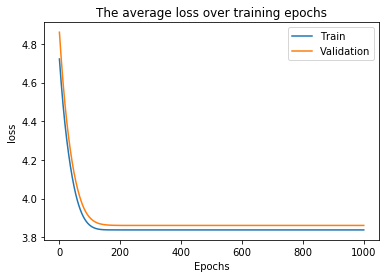

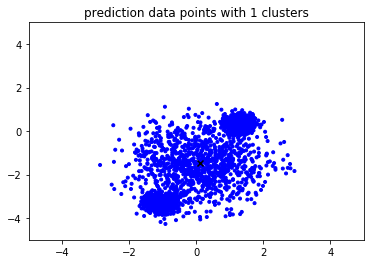

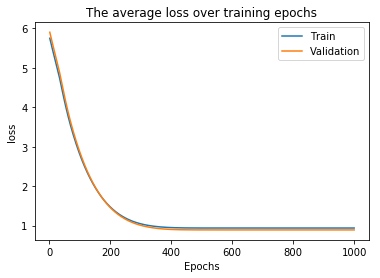

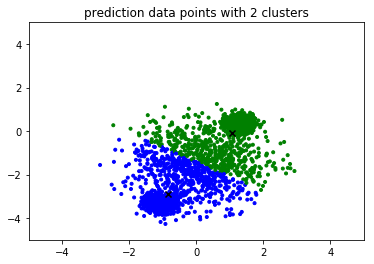

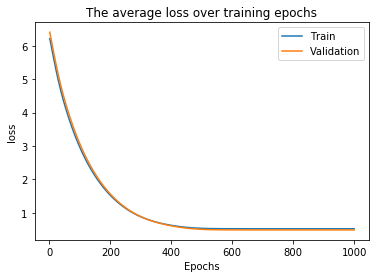

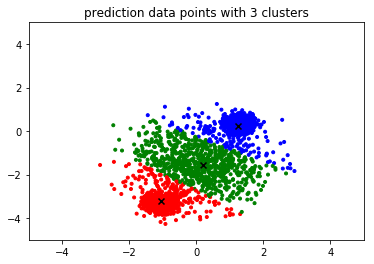

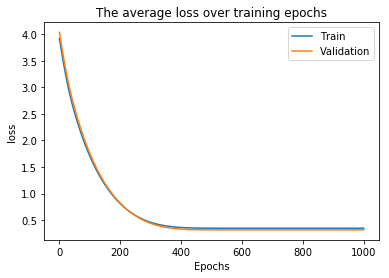

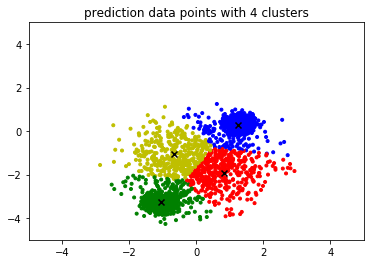

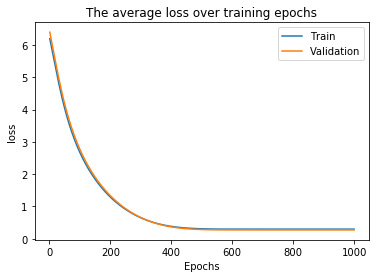

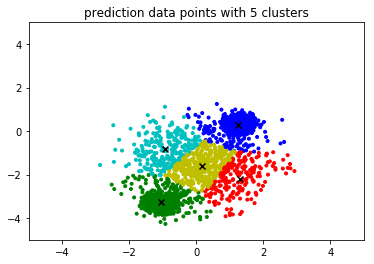

In [10]:
if __name__ == '__main__':
    for num_cluster in [1,2,3,4,5]:
        part1(k=num_cluster, epochs=1000)